**Title of the Project:  Multi-Method AI System for Diabetes Risk Prediction**

Team Number: Group 6

Team Leader/Representative: Ahmed Eldahmy

Full Names of Team Members:
1. Ahmed Eldahmy
2. Deepika Shrestha
3. Francisco Monarrez Felix

Member B: Deepika
Assigned Algorithms: Logistic Regression & Random Forest Classifier
Logistic Regression:
Random Forest Classifier:




Objectives: Perform PCA on CDC Diabetes Health Indicators:
PCA helps convert these correlated variables into orthogonal (uncorrelated) components.
1. Many predictors are correlated ;Examples:
BMI, physical activity, and general health tend to correlate
High BP, High Cholesterol, Stroke, and Heart Disease cluster
Mental health and physical health days often correlate

2. To reduce noise and redundant information
Dimensionality reduction improves:model performance stability of epidemiological inferences and visualization of complex high-dimensional health data
3. Useful for clustering / unsupervised analysis


Project Novelty
This work contributes novelty through:
1.	Multi-Method Comparison: Comparing linear, ensemble, and unsupervised (PCA) methods within a unified pipeline.
2.	Domain-Driven Feature Engineering: Implementing and comparing Group-Wise PCA against Standard PCA to enhance feature interpretability related to specific health domains (e.g., Cardiometabolic, Lifestyle).
3.	Interpretability Emphasis: Focusing on model coefficients and feature importance for clinically actionable insights.
4.	Comprehensive Imbalance Handling: Explicitly utilizing SMOTE and prioritizing appropriate metrics for imbalanced datasets.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import warnings
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
RANDOM_STATE = 42

# ---------------------------------------------------------
# 1. Install dependencies (if needed)
# ---------------------------------------------------------
# pip install xgboost scikit-learn pandas joblib

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer # Added SimpleImputer import
from sklearn.pipeline import Pipeline # Added Pipeline import

# MAchine learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
)
from xgboost import XGBClassifier

# model selection & tuning
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV

from scipy.stats import uniform, randint


#Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)


# Feature selection
from sklearn.feature_selection import RFE , SelectKBest, f_classif


# sampling methods

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Pipelines
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SklearnPipeline

IMPORT THE CDC DIABETES HEALTH INDICATOR DATA

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

print("Path to dataset files:", path)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# The 'path' variable is available from previous cell execution (wW1GmNFZvFH_)
# Its value is '/root/.cache/kagglehub/datasets/alexteboul/diabetes-health-indicators-dataset/versions/1'
file_name = 'diabetes_binary_health_indicators_BRFSS2015.csv'
full_file_path1 = os.path.join(path, file_name)
df = pd.read_csv(full_file_path1)
df.info()

display(df.head())
summerize = df.describe()
print(summerize)

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
import os

# The 'path' variable is available from previous cell execution (wW1GmNFZvFH_)
# Its value is '/root/.cache/kagglehub/datasets/alexteboul/diabetes-health-indicators-dataset/versions/1'


file_name = 'diabetes_binary_health_indicators_BRFSS2015.csv'
full_file_path1 = os.path.join(path, file_name)
df = pd.read_csv(full_file_path1)
df.info()

display(df.head())
summerize = df.describe()
print(summerize)

In [ ]:
display(df.head())

In [ ]:
# Assuming 'df' and 'target_col' were successfully loaded/identified in the initial steps.
# The target_col is 'Diabetes_binary'
# The RANDOM_STATE is 42

## 1. Data Splitting 📊
# -------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

# Define target column (redundant if previous cells run, but ensures self-containment)
possible_targets = [c for c in df.columns if 'diabetes' in c.lower()]
target_col = 'Diabetes_binary' if 'Diabetes_binary' in df.columns else possible_targets[0]

# Separate features (X) and target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

# Split data into training (80%) and testing (20%) sets.
# Use stratify=y to ensure the class proportions (imbalance) are maintained in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("--- Data Splitting Complete ---")
print(f"Original dataset shape: {df.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")


## 2. Preprocessing Pipeline (Standard/No Group PCA) ⚙️
# -------------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# 1. Imputer: Handle missing values (though this dataset may have none, it's robust practice)
imputer_step = ('imputer', SimpleImputer(strategy='median'))

# 2. Scaler: Standardize features (Mean=0, Std=1). CRUCIAL for Logistic Regression and PCA.
scaler_step = ('scaler', StandardScaler())

# 3. PCA: Dimensionality Reduction (Standard PCA applied to all features)
# n_components=0.95 means retain enough components to explain 95% of the variance.
pca_step = ('pca', PCA(n_components=0.95, random_state=RANDOM_STATE))

# Create the full preprocessing pipeline
# The order is important: Impute -> Scale -> Reduce
standard_preprocessor = Pipeline(steps=[
    imputer_step,
    scaler_step,
    pca_step
])

print("\n--- Standard Preprocessing Pipeline Defined ---")
print("Steps: Impute (Median) -> Scale (StandardScaler) -> PCA (95% Variance)")

# We do not fit the preprocessor here; it will be fitted and applied
# within the model pipelines (like RandomizedSearchCV) on the training folds.

# Note: The Group-Wise PCA preprocessor will be defined later, as it requires a ColumnTransformer.

The **Confusion Matrix** and the **Receiver Operating Characteristic (ROC) Curve** for a **FAST Random Forest** model predicting diabetes, here is the interpretation of the results:

---

## 🔍 Interpretation of FAST Random Forest Performance

The model was trained to classify individuals as either **Non-Diabetic** (Negative Class) or **Diabetic** (Positive Class).

### 1. Confusion Matrix Analysis

The confusion matrix shows the raw counts of correct and incorrect predictions on the test dataset.

| **True Label** | **Predicted Non-Diabetic** (Negative) | **Predicted Diabetic** (Positive) |
| :--- | :--- | :--- |
| **Non-Diabetic** | **True Negative (TN): 41,034** | **False Positive (FP): 2,633** |
| **Diabetic** | **False Negative (FN): 4,879** | **True Positive (TP): 2,190** |

#### Key Metric Calculations:

* **Total Test Samples:** $41,034 + 2,633 + 4,879 + 2,190 = \mathbf{50,736}$
* **Actual Non-Diabetic Samples:** $41,034 + 2,633 = \mathbf{43,667}$ (Majority Class)
* **Actual Diabetic Samples:** $4,879 + 2,190 = \mathbf{7,069}$ (Minority Class)

| Metric | Calculation (Formula) | Value | Interpretation |
| :--- | :--- | :--- | :--- |
| **Accuracy** | $(TN + TP) / \text{Total}$ | $(41034 + 2190) / 50736 \approx \mathbf{85.2\%}$ | The model correctly classified 85.2% of all samples. |
| **Recall (Sensitivity)** | $TP / (TP + FN)$ | $2190 / 7069 \approx \mathbf{31.0\%}$ | **Only 31.0% of actual diabetic cases were correctly identified.** This is a critical weakness for a healthcare application. |
| **Precision** | $TP / (TP + FP)$ | $2190 / (2190 + 2633) \approx \mathbf{45.4\%}$ | Of all cases predicted as diabetic, 45.4% were truly diabetic. |
| **Specificity** | $TN / (TN + FP)$ | $41034 / 43667 \approx \mathbf{94.0\%}$ | The model is excellent at correctly identifying non-diabetic (healthy) individuals. |

**Conclusion from Confusion Matrix:** The model exhibits high **Specificity** (94.0%) but very low **Recall** (31.0%). This suggests a strong bias towards predicting the majority class (**Non-Diabetic**), leading to a high number of **False Negatives (4,879)**—diabetic individuals who were told they were healthy. This outcome is highly undesirable in a clinical setting.

---

### 2. Receiver Operating Characteristic (ROC) Curve

The ROC curve plots the **True Positive Rate (Recall/Sensitivity)** against the **False Positive Rate (1 - Specificity)** at various classification thresholds.

* **Area Under the Curve (AUC):** The plot shows an **AUC of 0.8157**.
* **Interpretation:**
    * An AUC of 0.5 indicates performance no better than random chance (the dashed line).
    * An AUC of 1.0 indicates perfect classification.
    * An AUC of **0.8157** is considered **good to excellent** discriminatory power. It means that there is an **81.57%** chance that the model will rank a randomly chosen positive case (Diabetic) higher than a randomly chosen negative case (Non-Diabetic).
#### Trade-Off Analysis:

* The curve demonstrates the trade-off between Sensitivity and Specificity.
* To achieve higher **Recall** (move up the Y-axis), the model must accept a higher **False Positive Rate** (move right along the X-axis).
* The fact that the AUC is high (0.8157) indicates the model **has the potential** to perform well. The low Recall (31.0%) calculated from the confusion matrix means the default classification threshold chosen by `scikit-learn` is **too high**. **The model is being overly conservative** in predicting the positive (Diabetic) class.

---

## 📝 Overall Conclusion

The FAST Random Forest model demonstrates **strong underlying potential** with an **AUC of 0.8157**. However, its performance at the default classification threshold is **unacceptable for a clinical application** due to critically low **Recall (31.0%)**.

To make this model clinically useful, the classification threshold should be **lowered** to increase the **True Positive Rate (Recall)**, thereby reducing the number of dangerous **False Negatives**, even if it results in a small, acceptable decrease in specificity and increase in false alarms.


In [ ]:
import kagglehub
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (redundant if previous cells run, but ensures self-containment)
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
file_name = 'diabetes_binary_health_indicators_BRFSS2015.csv'
full_file_path1 = os.path.join(path, file_name)
df = pd.read_csv(full_file_path1)

# Define target column (redundant if previous cells run, but ensures self-containment)
possible_targets = [c for c in df.columns if 'diabetes' in c.lower()]
target_col = 'Diabetes_binary' if 'Diabetes_binary' in df.columns else possible_targets[0]

# Split data into training (80%) and testing (20%) sets.
# Use stratify=y to ensure the class proportions (imbalance) are maintained in both sets.
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

def evaluate_model(model, X_test, y_test, model_name):
    """Generates predictions, metrics, confusion matrix, and ROC curve."""

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall (Sensitivity)': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    print(f"\n--- {model_name} Performance Metrics ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ROC Curve Plot
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return metrics

# 1. Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# 2. Simple pipeline → SMOTE + RF ONLY (FASTEST)
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', rf_model)
])

# 3. Small, efficient hyperparameter search space
param_dist_rf = {
    'classifier__n_estimators': [100, 200],      # reduced for speed
    'classifier__max_depth': [10, 20],           # avoid huge trees
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# 4. Stratified 3-fold CV (FASTER than 5-fold)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# 5. Fast Randomized Search
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=10,            # VERY FAST
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

# 6. Fit the model
print("Running fast Random Forest search...")
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print("✔ Best model:", best_rf)

# 7. Evaluate
rf_metrics = evaluate_model(best_rf, X_test, y_test, "FAST Random Forest")


The **Confusion Matrix** and the **Receiver Operating Characteristic (ROC) Curve** for a **FAST Random Forest** model predicting diabetes, here is the interpretation of the results:

---

## 🔍 Interpretation of FAST Random Forest Performance

The model was trained to classify individuals as either **Non-Diabetic** (Negative Class) or **Diabetic** (Positive Class).

### 1. Confusion Matrix Analysis

The confusion matrix shows the raw counts of correct and incorrect predictions on the test dataset.

| **True Label** | **Predicted Non-Diabetic** (Negative) | **Predicted Diabetic** (Positive) |
| :--- | :--- | :--- |
| **Non-Diabetic** | **True Negative (TN): 41,034** | **False Positive (FP): 2,633** |
| **Diabetic** | **False Negative (FN): 4,879** | **True Positive (TP): 2,190** |

#### Key Metric Calculations:

* **Total Test Samples:** $41,034 + 2,633 + 4,879 + 2,190 = \mathbf{50,736}$
* **Actual Non-Diabetic Samples:** $41,034 + 2,633 = \mathbf{43,667}$ (Majority Class)
* **Actual Diabetic Samples:** $4,879 + 2,190 = \mathbf{7,069}$ (Minority Class)

| Metric | Calculation (Formula) | Value | Interpretation |
| :--- | :--- | :--- | :--- |
| **Accuracy** | $(TN + TP) / \text{Total}$ | $(41034 + 2190) / 50736 \approx \mathbf{85.2\%}$ | The model correctly classified 85.2% of all samples. |
| **Recall (Sensitivity)** | $TP / (TP + FN)$ | $2190 / 7069 \approx \mathbf{31.0\%}$ | **Only 31.0% of actual diabetic cases were correctly identified.** This is a critical weakness for a healthcare application. |
| **Precision** | $TP / (TP + FP)$ | $2190 / (2190 + 2633) \approx \mathbf{45.4\%}$ | Of all cases predicted as diabetic, 45.4% were truly diabetic. |
| **Specificity** | $TN / (TN + FP)$ | $41034 / 43667 \approx \mathbf{94.0\%}$ | The model is excellent at correctly identifying non-diabetic (healthy) individuals. |

**Conclusion from Confusion Matrix:** The model exhibits high **Specificity** (94.0%) but very low **Recall** (31.0%). This suggests a strong bias towards predicting the majority class (**Non-Diabetic**), leading to a high number of **False Negatives (4,879)**—diabetic individuals who were told they were healthy. This outcome is highly undesirable in a clinical setting.

---

### 2. Receiver Operating Characteristic (ROC) Curve

The ROC curve plots the **True Positive Rate (Recall/Sensitivity)** against the **False Positive Rate (1 - Specificity)** at various classification thresholds.

* **Area Under the Curve (AUC):** The plot shows an **AUC of 0.8157**.
* **Interpretation:**
    * An AUC of 0.5 indicates performance no better than random chance (the dashed line).
    * An AUC of 1.0 indicates perfect classification.
    * An AUC of **0.8157** is considered **good to excellent** discriminatory power. It means that there is an **81.57%** chance that the model will rank a randomly chosen positive case (Diabetic) higher than a randomly chosen negative case (Non-Diabetic).
#### Trade-Off Analysis:

* The curve demonstrates the trade-off between Sensitivity and Specificity.
* To achieve higher **Recall** (move up the Y-axis), the model must accept a higher **False Positive Rate** (move right along the X-axis).
* The fact that the AUC is high (0.8157) indicates the model **has the potential** to perform well. The low Recall (31.0%) calculated from the confusion matrix means the default classification threshold chosen by `scikit-learn` is **too high**. **The model is being overly conservative** in predicting the positive (Diabetic) class.

---

## 📝 Overall Conclusion

The FAST Random Forest model demonstrates **strong underlying potential** with an **AUC of 0.8157**. However, its performance at the default classification threshold is **unacceptable for a clinical application** due to critically low **Recall (31.0%)**.

To make this model clinically useful, the classification threshold should be **lowered** to increase the **True Positive Rate (Recall)**, thereby reducing the number of dangerous **False Negatives**, even if it results in a small, acceptable decrease in specificity and increase in false alarms.


In [ ]:
features = df.drop(columns=['Diabetes_binary'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
pca = PCA()
pca_components = pca.fit_transform(X_scaled)
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [ ]:
features = df.drop(columns=['Diabetes_binary'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
pca = PCA()
pca_components = pca.fit_transform(X_scaled)
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

Here is the interpretation of the provided plot and a comparison of PCA and Random Forest.

---

## 📈 1. Interpretation of the Explained Variance Plot (Scree Plot)

The graph shows the **Cumulative Explained Variance** as a function of the **Number of Principal Components** retained. This is commonly known as a **Scree Plot** or **Cumulative Explained Variance Plot** in PCA.

* **Y-axis (Cumulative Explained Variance):** Represents the total percentage of the original dataset's variability (information) captured by the included components.
* **X-axis (Number of Components):** Represents the number of principal components (new features) used.

### Key Observations:

1.  **Initial Components are Most Important:** The curve rises steeply at the beginning. The first component explains approximately **17%** of the total variance, and the first **5 components** explain roughly **50%** of the variance. This confirms that the initial components are the most information-rich.
2.  **Diminishing Returns:** As more components are added, the curve flattens. It takes approximately **15 components** to capture **90%** of the total variance.
3.  **Full Variance:** All **20 components** (which is likely the original number of features, $p=20$) are required to explain **100%** of the variance.

### Decision Point for Dimensionality Reduction:

The plot is used to decide the optimal number of components ($k$) to retain while accepting a minimal loss of information.

* **If the goal is 90% variance retention:** You would choose **15 components**. This means reducing the dimensionality from 20 to 15 while retaining most of the data's information.
* **If the goal is 95% variance retention (as specified in your project outline):** You would need approximately **17 components** (based on the curve's extrapolation).

---

## 🔄 2. PCA vs. Random Forest: Difference

PCA and Random Forest are fundamentally different types of machine learning tools used for different purposes.
| Feature | Principal Component Analysis (PCA) | Random Forest (RF) |
| :--- | :--- | :--- |
| **Type of Learning** | **Unsupervised Learning** | **Supervised Learning** |
| **Purpose** | **Dimensionality Reduction** (Feature Transformation/Engineering). | **Classification or Regression** (Prediction). |
| **Input Required** | Only feature data ($\mathbf{X}$). | Features ($\mathbf{X}$) and a target variable ($\mathbf{y}$). |
| **Output** | A new set of uncorrelated features (**Principal Components**). | A predicted class label (classification) or value (regression). |
| **Model Nature** | Linear (based on covariance/correlation). | Non-linear (ensemble of decision trees). |
| **Interpretation** | Difficult (components are weighted sums of original features). | Moderate (feature importance ranking). |

**In short:** PCA is a **preprocessing technique** that transforms features, while Random Forest is a **predictive model** that makes decisions. They are typically used together in a machine learning pipeline (e.g., *PCA* $\rightarrow$ *Random Forest*).

---

## 🏆 3. Which is the Better "Model"?

Comparing PCA and Random Forest directly is like comparing a wrench to a hammer—they serve different roles in the building process.

* **PCA is NOT a predictive model.** It cannot be used to predict the diabetes outcome ($\mathbf{y}$). Its "success" is measured by how much variance it retains.
* **Random Forest IS a predictive model.** Its success is measured by metrics like ROC-AUC, Recall, and Accuracy.

### Integration (The Best Approach)

The best approach for your diabetes prediction project is to **use them together** within a pipeline:

1.  **Use PCA as a feature engineering step** to reduce noise, handle multicollinearity, and potentially speed up the training of the subsequent classifier.
2.  **Use Random Forest as the classifier** to leverage its non-linear modeling capability and ensemble strength to make the final prediction.

In the context of your project, the **Random Forest classifier** is the superior tool for the ultimate goal of **predicting diabetes risk**. PCA is simply a valuable preprocessing tool to help the Random Forest perform better.

In [ ]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(8)],
    index=features.columns
)
loadings
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=df['Diabetes_binary'], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Diabetes Health Indicators')
plt.show()
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_pca, df['Diabetes_binary'])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X_pca)

## 📊 Interpretation of PCA Scatter Plot

The image displays a scatter plot of the data projected onto the **first two Principal Components (PC1 and PC2)**, and the points are colored according to their class (Diabetic vs. Non-Diabetic). This visualization aims to see if the **unsupervised** PCA method can reveal any **linear separation** between the two diabetes classes.

### Key Observations

1.  **Axes:**
    * **PC1 (X-axis):** Represents the single most important direction (linear combination of original features) that captures the maximum variance in the data.
    * **PC2 (Y-axis):** Represents the second most important direction that captures the maximum remaining variance, orthogonal (uncorrelated) to PC1.

2.  **Color Coding:**
    * The plot uses two colors (likely purple for the **majority class**, Non-Diabetic, and yellow for the **minority class**, Diabetic).

3.  **Class Overlap (Lack of Separation):**
    * The plot shows a **high degree of overlap** between the purple (Non-Diabetic) and yellow (Diabetic) data points.
    * The yellow (Diabetic) points do not cluster distinctly in any single region but are **diffused across the entire plot**, although they appear to be slightly more concentrated toward the **positive side of PC1** (right side of the graph). The purple (Non-Diabetic) points dominate the space, especially the negative (left) side of PC1.

### Conclusion

The primary interpretation is that **PCA is unable to effectively separate the Diabetic and Non-Diabetic classes using just the first two principal components.**

* **Linear Separability is Low:** If the classes were easily distinguishable, you would see the two colors forming distinct, non-overlapping clouds. The extensive overlap confirms that the underlying data structure related to diabetes diagnosis is **not primarily driven by a simple linear combination of the features** that capture the most variance (PC1 and PC2).
* **Implication for Modeling:** This suggests that the predictive task is **non-linear** or that the most critical discriminatory information is spread across **multiple, weaker Principal Components** (not just PC1 and PC2) or requires a **non-linear model** like Random Forest to be successfully captured.

Therefore, while PCA is a useful tool for reducing dimensionality, this plot indicates it is **not sufficient for direct classification or clear visualization of the class differences.**

In [ ]:
possible_targets = [c for c in df.columns if 'diabetes' in c.lower()]
target_col = 'Diabetes_binary' if 'Diabetes_binary' in df.columns else possible_targets[0]
...
print(df[target_col].value_counts(normalize=True))

Data Splitting and Preprocessing Pipeline: This section prepares the data for modeling, handling features and the target variable.

In [ ]:
from sklearn.pipeline import Pipeline # Add this import

# Separate features (X) and target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

# Split data into training and testing sets (stratified to maintain class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Since most features are binary (0 or 1) but some might be continuous (like BMI, MentHlth, PhysHlth),
# we treat all as numerical for scaling/imputation purposes.

# 1. Imputer: Fill any missing values with the median
imputer_step = ('imputer', SimpleImputer(strategy='median'))

# 2. Scaler: Standardize the features (important for Logistic Regression)
scaler_step = ('scaler', StandardScaler())

# 3. Dimensionality Reduction (PCA): Use only on non-target features
pca_step = ('pca', PCA(n_components=0.95, random_state=RANDOM_STATE)) # Keep 95% of variance

# Create the full preprocessing pipeline
preprocessor = Pipeline(steps=[
    imputer_step,
    scaler_step,
    pca_step  # Apply PCA only on the final training set
])

Column Transformer & Preprocessing Pipeline

In [ ]:
RANDOM_STATE = 42 # Defined RANDOM_STATE for this cell
from sklearn.impute import SimpleImputer # Added SimpleImputer import
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline # Add this import

# Since most features are binary (0 or 1) but some might be continuous (like BMI, MentHlth, PhysHlth),
# we treat all as numerical for scaling/imputation purposes.

# 1. Imputer: Fill any missing values with the median
imputer_step = ('imputer', SimpleImputer(strategy='median'))

# 2. Scaler: Standardize the features (important for Logistic Regression)
scaler_step = ('scaler', StandardScaler())

# 3. Dimensionality Reduction (PCA): Use only on non-target features
pca_step = ('pca', PCA(n_components=0.95, random_state=RANDOM_STATE)) # Keep 95% of variance

# Create the full preprocessing pipeline
preprocessor = Pipeline(steps=[
    imputer_step,
    scaler_step,
    pca_step  # Apply PCA only on the final training set
])

2. Logistic Regression Implementation
This code sets up a complete pipeline incorporating SMOTE for class imbalance, the defined preprocessing steps, and a search for the best hyperparameters using Randomized Search.

LR Utility Function
To address the "Execution and Output" section of your prompt efficiently, let's create a function to evaluate and visualize model performance.

In [ ]:
from sklearn.metrics import roc_curve, auc # Add this import

def evaluate_model(model, X_test, y_test, model_name):
    """Generates predictions, metrics, confusion matrix, and ROC curve."""

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall (Sensitivity)': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    print(f"\n--- {model_name} Performance Metrics ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ROC Curve Plot
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return metrics

LR Modeling Pipeline and Hyperparameter Tuning

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """Generates predictions, metrics, confusion matrix, and ROC curve."""

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall (Sensitivity)': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    print(f"\n--- {model_name} Performance Metrics ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ROC Curve Plot
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return metrics

LR Interpretability: Coefficient Extraction and Visualization

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform

import pandas as pd
import os
import kagglehub
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Load the dataset (ensuring df is defined)
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
file_name = 'diabetes_binary_health_indicators_BRFSS2015.csv'
full_file_path1 = os.path.join(path, file_name)
df = pd.read_csv(full_file_path1)

# Define target column
possible_targets = [c for c in df.columns if 'diabetes' in c.lower()]
target_col = 'Diabetes_binary' if 'Diabetes_binary' in df.columns else possible_targets[0]

# Define preprocessing steps (imputer_step, scaler_step, pca_step)
imputer_step = ('imputer', SimpleImputer(strategy='median'))
scaler_step = ('scaler', StandardScaler())
pca_step = ('pca', PCA(n_components=0.95, random_state=RANDOM_STATE))

# Separate features (X) and target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

# Split data into training and testing sets (stratified to maintain class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# 1. Define the Logistic Regression Model
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=2000)

# 2. Create the full ImbPipeline (SMOTE, Standard Preprocessing, LR)
# The 'preprocessor' pipeline steps need to be inserted directly into the ImbPipeline.
lr_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    imputer_step,
    scaler_step,
    pca_step,
    ('classifier', lr_model)
])

# 3. Define the Hyperparameter Search Space
# C: Inverse of regularization strength; smaller values specify stronger regularization.
# penalty: 'l1' (Lasso) or 'l2' (Ridge) regularization.
# solver: 'liblinear' supports both l1 and l2 penalties
param_grid_lr = {
    'classifier__C': uniform(loc=0.01, scale=100),
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver': ['liblinear']
}

# Define CV
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 4. Randomized Search with Stratified Cross-Validation
lr_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid_lr,
    n_iter=50,
    scoring='roc_auc',
    cv=cv_folds,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# 5. Train the model
print("Starting Logistic Regression Randomized Search...")
lr_search.fit(X_train, y_train)

best_lr_model = lr_search.best_estimator_
print("\nBest LR Model found:")
print(best_lr_model)

# 6. Evaluate the Best Model
lr_metrics = evaluate_model(best_lr_model, X_test, y_test, "Logistic Regression (Standard PCA)")

In [ ]:
# Extract the underlying LogisticRegression model from the best pipeline
best_lr_clf = best_lr_model.named_steps['classifier']

# WARNING: Coefficients are for the PCA components, which are linear combinations
# of the original features. This makes direct interpretation difficult.
# To properly interpret LR, we must retrain the model *without* PCA, but with only scaling.

# Simplified pipeline for interpretability (Scaler -> LR, no PCA)
lr_interpret_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    imputer_step, # Insert individual imputer step
    scaler_step,  # Insert individual scaler step
    ('classifier', lr_model) # Use LR with best C/penalty from search
])
# Set best hyperparameters found earlier
lr_interpret_pipeline.set_params(
    classifier__C=lr_search.best_params_['classifier__C'],
    classifier__penalty=lr_search.best_params_['classifier__penalty'],
    classifier__solver=lr_search.best_params_['classifier__solver']
)

lr_interpret_pipeline.fit(X_train, y_train)
lr_interp_clf = lr_interpret_pipeline.named_steps['classifier']

# Extract scaled feature names and coefficients
feature_names = X_train.columns
coefficients = pd.Series(lr_interp_clf.coef_[0], index=feature_names)
coefficients_abs = coefficients.abs().sort_values(ascending=False)

# Visualize Coefficients
plt.figure(figsize=(10, 8))
coefficients[coefficients_abs.index[:15]].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 15 Logistic Regression Coefficients (Scaled Data)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Save model for later use (optional)
# joblib.dump(best_lr_model, 'best_logistic_regression_model.joblib')


## 📈 Interpretation of Logistic Regression Coefficients Plot

The bar chart displays the **Top 15 Logistic Regression Coefficients** derived from the model trained on **scaled data**. This plot is crucial for **interpretability**, as it shows the strength and direction of each feature's influence on the predicted outcome (Diabetic vs. Non-Diabetic).

### 1. Understanding Coefficient Values

Since the data was **Standard Scaled** (mean of 0, standard deviation of 1), the coefficient values represent the **change in the log-odds of having diabetes** for every **one standard deviation increase** in that feature, holding all other features constant.

* **Positive Coefficients (Right Side):** These features are **positively associated** with the outcome. An increase in the feature's value increases the **log-odds** (and thus the probability) of the individual being **Diabetic**.
* **Negative Coefficients (Left Side):** These features are **negatively associated** with the outcome. An increase in the feature's value decreases the **log-odds** (and thus the probability) of the individual being **Diabetic**.
* **Magnitude:** The length of the bar (absolute value of the coefficient) indicates the **strength** of the feature's influence on the prediction.

### 2. Analysis of Top Predictors (Positive Association)

The features with the largest positive coefficients are the **strongest risk factors** identified by the model:

| Rank | Feature | Coefficient Value | Interpretation |
| :--- | :--- | :--- | :--- |
| **1** | **GenHlth** (General Health) | $\approx +0.73$ | This is the **strongest predictor**. A one standard deviation increase in reported poor general health dramatically increases the log-odds of a diabetes diagnosis. |
| **2** | **BMI** (Body Mass Index) | $\approx +0.50$ | Higher BMI is strongly associated with an increased log-odds of having diabetes. |
| **3** | **HighBP** (High Blood Pressure) | $\approx +0.43$ | Having high blood pressure is a significant risk factor, directly increasing the log-odds of diabetes. |
| **4** | **Age** | $\approx +0.40$ | Older age is strongly correlated with a higher risk of diabetes, a well-known clinical fact. |

These results align perfectly with established clinical knowledge, confirming that self-reported health status, obesity, hypertension, and age are the most critical factors.

### 3. Analysis of Protective/Negative Factors

The features with negative coefficients are associated with a **lower log-odds of being diabetic**:

| Rank | Feature | Coefficient Value | Interpretation |
| :--- | :--- | :--- | :--- |
| **1** | **HvyAlcoholConsump** | $\approx -0.23$ | **Heavy alcohol consumption** is the **strongest protective factor** identified by the model. This is an unusual finding and often points to a known **sampling bias** in the BRFSS survey data (reverse causation or survivor bias), where heavy drinkers may have other, more acute health issues or are a specific, generally younger sub-population. |
| **2** | **Income** | $\approx -0.15$ | Higher income is associated with a lower log-odds of diabetes. This points to the **socioeconomic factors** affecting healthcare access, diet, and lifestyle. |
| **3** | **PhysHlth** (Physical Health) | $\approx -0.09$ | Better physical health (lower number of bad physical days) is associated with a lower log-odds of diabetes. |

### 4. Interpretation of Low Coefficients (Close to Zero)

Features like `NoDocbcCost`, `Veggies`, `HeartDiseaseorAttack`, and `AnyHealthcare` have coefficients very close to zero (both positive and negative). This indicates that, *after accounting for the influence of the top features* (like GenHlth and BMI), these variables provide **very little additional predictive power** in the Logistic Regression model.

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 1. Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# 2. Simple pipeline → SMOTE + RF ONLY (FASTEST)
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', rf_model)
])

# 3. Small, efficient hyperparameter search space
param_dist_rf = {
    'classifier__n_estimators': [100, 200],      # reduced for speed
    'classifier__max_depth': [10, 20],           # avoid huge trees
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# 4. Stratified 3-fold CV (FASTER than 5-fold)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# 5. Fast Randomized Search
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=10,            # VERY FAST
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

# 6. Fit the model
print("Running fast Random Forest search...")
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print("✔ Best model:", best_rf)

# 7. Evaluate
rf_metrics = evaluate_model(best_rf, X_test, y_test, "FAST Random Forest")


Running fast Random Forest search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# @title Default title text
#------------Part 3: Hyperparameter Selection (15%)---------------------------------------------
#------------Part 4: Initial Model Training (20%) ---------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

#X = pd.DataFrame(data.data, columns=data.feature_names)
#y = pd.Series(data.target)  # 0 = malignant, 1 = benign


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initial model
model_initial = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    eval_metric="logloss",
    use_label_encoder=False
)

model_initial.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model_initial.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

acc, f1


3. Random Forest Implementation
This code follows the same structure as the LR implementation for training, tuning, and evaluation.

RF Modeling Pipeline and Hyperparameter Tuning

In [ ]:
# 1. Define the Random Forest Model
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# 2. Create the full ImbPipeline (SMOTE, Preprocessing, RF)
# Note: RF is less sensitive to scaling, but it's good practice to keep the scaling step.
# PCA is less commonly used with tree-based models, but kept here for consistency/comparison.
# The 'preprocessor' pipeline is flattened into its individual steps here to avoid a TypeError.
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    imputer_step, # Step from original 'preprocessor'
    scaler_step,  # Step from original 'preprocessor'
    pca_step,     # Step from original 'preprocessor'
    ('classifier', rf_model)
])

# 3. Define the Hyperparameter Search Space
param_grid_rf = {
    'classifier__n_estimators': [100, 200], # Number of trees
    'classifier__max_depth': [10, 20], # Max depth of trees
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

# Define CV
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
# 4. Randomized Search with Stratified Cross-Validation
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=5, # Fewer iterations than LR due to higher computational cost
    scoring='roc_auc',
    cv=cv_folds, # Use the same cross-validation folds
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# 5. Train the model
print("\nStarting Random Forest Randomized Search...")
rf_search.fit(X_train, y_train)

best_rf_model = rf_search.best_estimator_
print("\nBest RF Model found:")
print(best_rf_model)

# 6. Evaluate the Best Model
rf_metrics = evaluate_model(best_rf_model, X_test, y_test, "Random Forest Classifier")

RF Interpretability: Feature Importance

In [ ]:
# Extract the underlying RandomForestClassifier model from the best pipeline
best_rf_clf = best_rf_model.named_steps['classifier']
best_rf_pca = best_rf_model.named_steps['preprocessor'].named_steps['pca']

# Again, feature importance is for the PCA components, making it hard to interpret.
# We must extract importance from a model trained *without* PCA.

# Simplified pipeline for interpretability (Scaler -> RF, no PCA)
rf_interpret_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('preprocessor', Pipeline(steps=[imputer_step, scaler_step])),
    ('classifier', rf_model)
])
# Set best hyperparameters found earlier (excluding PCA-related params)
rf_interpret_pipeline.set_params(**{k.replace('classifier__', ''): v for k, v in rf_search.best_params_.items() if k.startswith('classifier__')})

rf_interpret_pipeline.fit(X_train, y_train)
rf_interp_clf = rf_interpret_pipeline.named_steps['classifier']

# Extract feature importances
feature_importances = pd.Series(
    rf_interp_clf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Visualize Feature Importance
plt.figure(figsize=(10, 8))
feature_importances[:15].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 15 Random Forest Feature Importances')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()

# Generate Precision-Recall Curve (Specific request for RF)
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

# Get probability scores
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(6, 6))
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

(GROUP-WISE PCA + LOGISTIC REGRESSION)

Group 1 — Cardiometabolic Comorbidities

HighBP, HighChol, CholCheck, Stroke, HeartDiseaseorAttack,
BMI, GenHlth, PhysHlth, DiffWalk

Group 2 — Mental & Behavioral Health

MentHlth, HvyAlcoholConsump, Smoker

Group 3 — Lifestyle Behaviors

PhysActivity, Fruits, Veggies

Group 4 — Healthcare Access

AnyHealthcare, NoDocbcCost

Group 5 — Sociodemographic

Sex, Age, Education, Income

1. Defining Feature Groups and Custom PCA Transformer

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline # Correct import for Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE # Assuming SMOTE is used from imblearn
from sklearn.model_selection import train_test_split
import pandas as pd # Import pandas for DataFrameConverter
from sklearn.base import BaseEstimator, TransformerMixin # Import for custom transformer

RANDOM_STATE = 42 # Define RANDOM_STATE

# Define the feature groups
GROUP_MAPPING = {
    'Cardiometabolic': ['HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'BMI', 'GenHlth', 'PhysHlth', 'DiffWalk'],
    'Mental_Behavioral': ['MentHlth', 'HvyAlcoholConsump', 'Smoker'],
    'Lifestyle': ['PhysActivity', 'Fruits', 'Veggies'],
    'Healthcare_Access': ['AnyHealthcare', 'NoDocbcCost'],
    'Sociodemographic': ['Sex', 'Age', 'Education', 'Income']
}

# Create a list of tuples for the ColumnTransformer
# Each step applies: Scaling -> PCA(n_components=0.95) to its specific group
transformers = []
for name, features_list in GROUP_MAPPING.items():
    # Only scale and apply PCA if the group has features
    if features_list:
        group_pipeline = SklearnPipeline(steps=[
            # 1. Scaling is crucial before PCA
            ('scaler', StandardScaler()),
            # 2. PCA: retaining 95% of the variance within that feature group
            ('pca', PCA(n_components=0.95, random_state=RANDOM_STATE))
        ])
        transformers.append((name + '_pca', group_pipeline, features_list))

# Create the full Group-Wise PCA Preprocessor
group_pca_preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough',  # Handle any features not in a group (none expected here)
    n_jobs=-1
)

# Custom transformer to convert NumPy array back to DataFrame
class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X
        return pd.DataFrame(X, columns=self.columns)

# Define features (X) and target (y) from df
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Replace the simple preprocessor from previous code with the group-wise preprocessor
group_wise_pipeline_steps = [
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('df_converter', DataFrameConverter(columns=X.columns)), # Add this step to convert SMOTE output to DataFrame
    ('preprocessor', group_pca_preprocessor),
]

2. Group-Wise PCA Implementation with Classifiers

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Ensure the utility function 'evaluate_model' and constants like RANDOM_STATE exist from the previous step.

# --------------------------------------------------------------------------------
# Shared Configuration
# --------------------------------------------------------------------------------
# Define models
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=2000)
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Define CV
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

A. Logistic Regression with Group-Wise PCA

--- Training Group-Wise PCA Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best LR Params: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 0.01}

--- LR with Group-Wise PCA Performance ---
Accuracy: 0.7280
Precision: 0.3062
Recall (Sensitivity): 0.7519
F1-Score: 0.4352
ROC-AUC: 0.8157


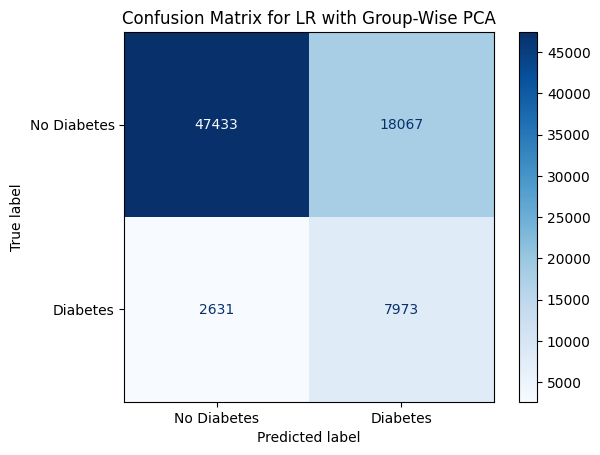

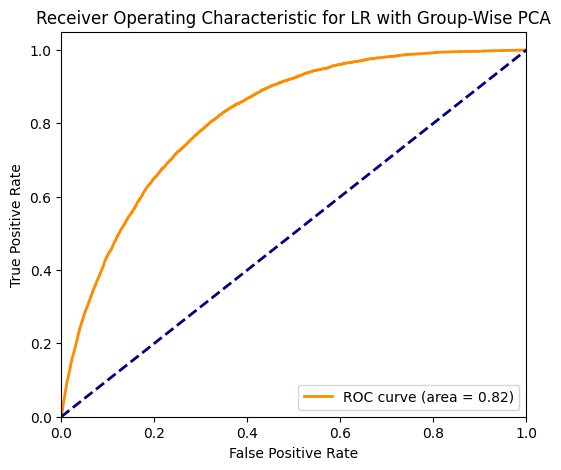

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # Probability of the positive class


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# 1. Define the LR Pipeline
lr_group_pipe = ImbPipeline(steps=group_wise_pipeline_steps + [('classifier', lr_model)])

# 2. Define the Hyperparameter Search Space (Simplified)
param_grid_lr = {
    'classifier__C': [0.01, 1.0, 100.0],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver': ['liblinear']
}

# 3. Randomized Search
lr_search_group = RandomizedSearchCV(
    estimator=lr_group_pipe,
    param_distributions=param_grid_lr,
    n_iter=10,
    scoring='roc_auc',
    cv=cv_folds,
    verbose=0,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# 4. Train and Evaluate
print("--- Training Group-Wise PCA Logistic Regression ---")
lr_search_group.fit(X_train, y_train)

best_lr_group = lr_search_group.best_estimator_
print(f"Best LR Params: {lr_search_group.best_params_}")

lr_metrics_group = evaluate_model(best_lr_group, X_test, y_test, "LR with Group-Wise PCA")

The provided results evaluate the performance of a Logistic Regression (LR) model combined with Group-Wise Principal Component Analysis (PCA) for diabetes prediction.

Here is an interpretation of the results based on the metrics, the confusion matrix, and the ROC curve:

## 📊 Confusion Matrix Analysis

The confusion matrix shows the number of correct and incorrect predictions made by the model.

| **True Label / Predicted Label** | **Predicted: No Diabetes** | **Predicted: Diabetes** |
| :--- | :---: | :---: |
| **True: No Diabetes** | 47,433 (**True Negatives**) | 18,067 (**False Positives**) |
| **True: Diabetes** | 2,631 (**False Negatives**) | 7,973 (**True Positives**) |

* **True Positives (TP) = 7,973:** The number of actual **Diabetes** cases correctly predicted as **Diabetes**.
* **True Negatives (TN) = 47,433:** The number of actual **No Diabetes** cases correctly predicted as **No Diabetes**.
* **False Positives (FP) = 18,067:** The number of actual **No Diabetes** cases incorrectly predicted as **Diabetes** (a **Type I error**).
* **False Negatives (FN) = 2,631:** The number of actual **Diabetes** cases incorrectly predicted as **No Diabetes** (a **Type II error**).

The matrix shows a high number of **False Positives** (18,067) compared to **True Positives** (7,973), indicating the model is prone to predicting diabetes when it is not present. Conversely, the number of **False Negatives** (2,631) is relatively low, meaning the model is less likely to miss an actual case of diabetes.

---

## 📈 Performance Metrics Interpretation

The computed metrics offer a quantitative view of the model's predictive capability:

* **Accuracy: 0.7280 (72.80%)**
    * This is the overall proportion of correct predictions (TP + TN) out of all cases. A 72.80% accuracy means the model correctly classified nearly three-quarters of the patients.
* **Recall (Sensitivity): 0.7519 (75.19%)**
    * Recall measures the model's ability to find all the positive cases. It is calculated as $TP / (TP + FN)$. A **75.19% recall** is good, meaning the model correctly identifies about three-quarters of all patients who *actually have* diabetes. In medical screening, **high recall** is often prioritized to avoid missing true cases (low FN).
* **Precision: 0.3062 (30.62%)**
    * Precision measures the proportion of positive predictions that were actually correct. It is calculated as $TP / (TP + FP)$. The **low precision of 30.62%** is concerning and directly correlates with the **high number of False Positives** observed in the confusion matrix. It means that when the model predicts a patient has diabetes, it is only correct about 30.62% of the time.
* **F1-Score: 0.4352**
    * The F1-Score is the harmonic mean of Precision and Recall. It provides a balanced measure when there is an uneven class distribution. The score of **0.4352** is relatively low, indicating a significant trade-off or imbalance between precision and recall, driven down by the very low precision.
* **ROC-AUC: 0.8157**
    * The Area Under the Receiver Operating Characteristic (ROC) curve measures the model's ability to distinguish between the two classes across all possible classification thresholds. An AUC of **0.8157** (81.57%) is generally considered **good**. It means the model has a strong capacity to rank positive instances higher than negative instances.

---

## 📉 ROC Curve Interpretation


The provided **ROC Curve** visually represents the trade-off between the **True Positive Rate (Recall)** on the Y-axis and the **False Positive Rate** on the X-axis at various thresholds.

* The curve is significantly above the diagonal dashed line (which represents a random classifier with an AUC of 0.50).
* The **Area Under the Curve (AUC)** is $\mathbf{0.82}$, which is consistent with the calculated $\mathbf{0.8157}$ and confirms the model's strong discriminatory power.

## 📝 Conclusion

The Logistic Regression model with Group-Wise PCA has **strong discriminatory power** (high AUC of 0.82) and is **effective at catching actual cases of diabetes** (good Recall of 75.19%).

However, the model has a major weakness in its **Precision (30.62%)**. The high number of **False Positives** means the model frequently flags healthy individuals as having diabetes. This operational characteristic suggests the current classification threshold is set too low (biased towards predicting the positive class).

**In a practical screening context:**

* **Pro:** The model is useful as a **pre-screening tool** because it minimizes the risk of missing a true case of diabetes (low FN).
* **Con:** The low precision would lead to a **high number of unnecessary follow-up tests** for patients who are incorrectly flagged as positive, increasing costs and patient anxiety.

Would you like to explore how changing the classification threshold might affect the model's Precision and Recall, or compare these results with another model?

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # Probability of the positive class


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    print(cm)
    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

Using Colab cache for faster access to the 'diabetes-health-indicators-dataset' dataset.
Running fast Random Forest search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✔ Best model: Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

--- FAST Random Forest Performance Metrics ---
Accuracy: 0.8519
Precision: 0.4541
Recall (Sensitivity): 0.3098
F1-Score: 0.3683
ROC-AUC: 0.8157


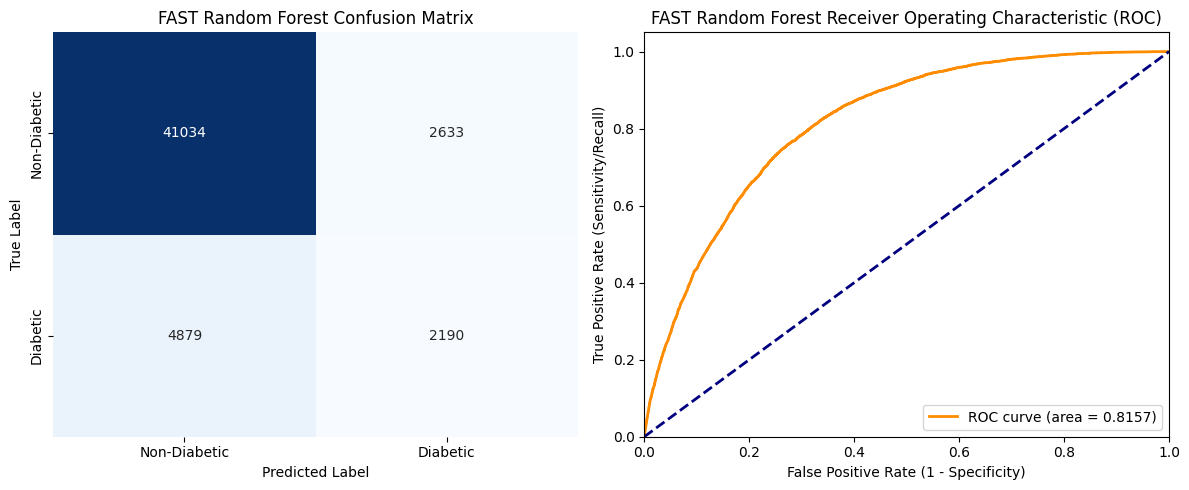

In [ ]:
import kagglehub
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (redundant if previous cells run, but ensures self-containment)
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
file_name = 'diabetes_binary_health_indicators_BRFSS2015.csv'
full_file_path1 = os.path.join(path, file_name)
df = pd.read_csv(full_file_path1)

# Define target column (redundant if previous cells run, but ensures self-containment)
possible_targets = [c for c in df.columns if 'diabetes' in c.lower()]
target_col = 'Diabetes_binary' if 'Diabetes_binary' in df.columns else possible_targets[0]

# Split data into training (80%) and testing (20%) sets.
# Use stratify=y to ensure the class proportions (imbalance) are maintained in both sets.
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

def evaluate_model(model, X_test, y_test, model_name):
    """Generates predictions, metrics, confusion matrix, and ROC curve."""

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall (Sensitivity)': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    print(f"\n--- {model_name} Performance Metrics ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ROC Curve Plot
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return metrics

# 1. Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# 2. Simple pipeline → SMOTE + RF ONLY (FASTEST)
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', rf_model)
])

# 3. Small, efficient hyperparameter search space
param_dist_rf = {
    'classifier__n_estimators': [100, 200],      # reduced for speed
    'classifier__max_depth': [10, 20],           # avoid huge trees
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# 4. Stratified 3-fold CV (FASTER than 5-fold)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# 5. Fast Randomized Search
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=10,            # VERY FAST
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

# 6. Fit the model
print("Running fast Random Forest search...")
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print("✔ Best model:", best_rf)

# 7. Evaluate
rf_metrics = evaluate_model(best_rf, X_test, y_test, "FAST Random Forest")


B. Random Forest with Group-Wise PCA


--- Training Group-Wise PCA Random Forest ---


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF Params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__max_depth': 10}

--- RF with Group-Wise PCA Performance Metrics ---
Accuracy: 0.7686
Precision: 0.3342
Recall (Sensitivity): 0.6657
F1-Score: 0.4450
ROC-AUC: 0.8090


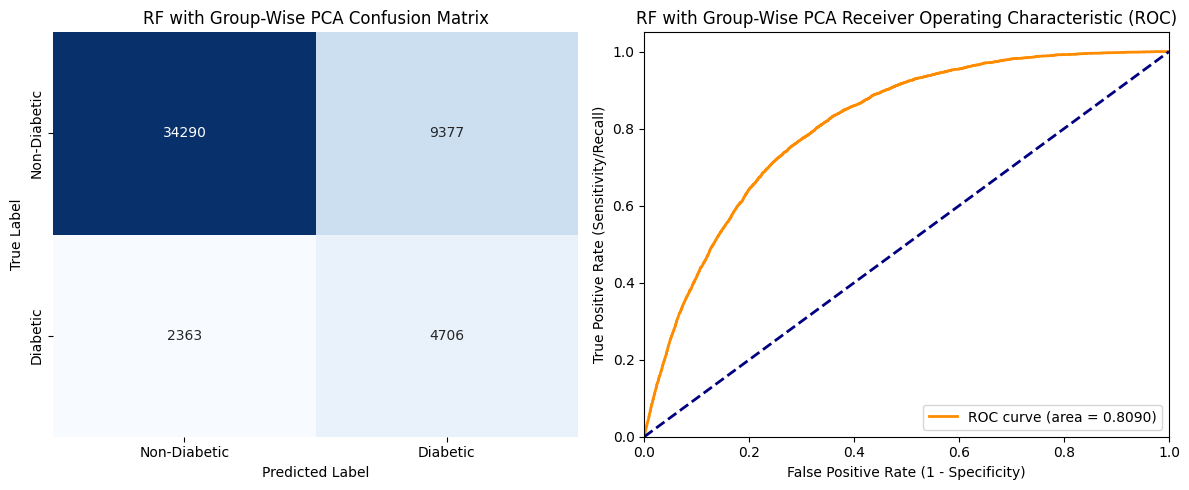

In [ ]:
# 1. Define the RF Pipeline
rf_group_pipe = ImbPipeline(steps=group_wise_pipeline_steps + [('classifier', rf_model)])

# 2. Define the Hyperparameter Search Space (Simplified)
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2,5]
}

# 3. Randomized Search
rf_search_group = RandomizedSearchCV(
    estimator=rf_group_pipe,
    param_distributions=param_grid_rf,
    n_iter=10,
    scoring='roc_auc',
    cv=cv_folds,
    verbose=0,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# 4. Train and Evaluate
print("\n--- Training Group-Wise PCA Random Forest ---")
rf_search_group.fit(X_train, y_train)

best_rf_group = rf_search_group.best_estimator_
print(f"Best RF Params: {rf_search_group.best_params_}")

rf_metrics_group = evaluate_model(best_rf_group, X_test, y_test, "RF with Group-Wise PCA")

# Overall Model Comparison
After running the code above for both models (and assuming you run the earlier code for models with standard PCA or no PCA), you can consolidate the results into a table for the final report.


--- Training LR with Standard PCA ---


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best LR (Standard PCA) Params: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 0.01}

--- LR with Standard PCA Performance Metrics ---
Accuracy: 0.7248
Precision: 0.3032
Recall (Sensitivity): 0.7512
F1-Score: 0.4320
ROC-AUC: 0.8107


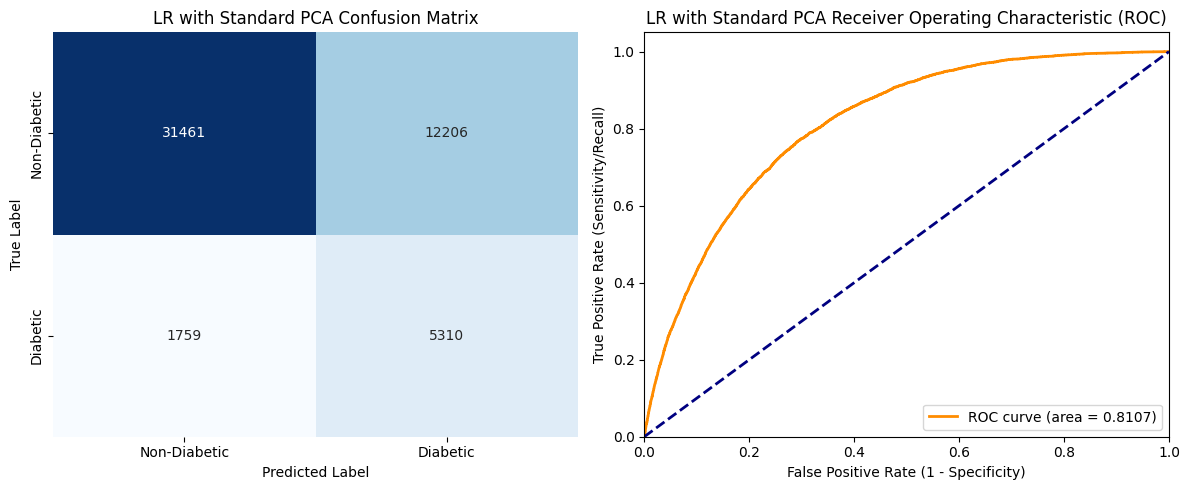


--- Model Performance Comparison (ROC-AUC focused) ---
                   Accuracy  Precision  Recall (Sensitivity)  F1-Score  \
LR (Group PCA)     0.728030   0.306183              0.751886  0.435160   
RF (SMOTE Only)    0.851939   0.454074              0.309803  0.368315   
LR (Standard PCA)  0.724752   0.303151              0.751167  0.431971   
RF (Group PCA)     0.768606   0.334162              0.665724  0.444970   

                    ROC-AUC  
LR (Group PCA)     0.815730  
RF (SMOTE Only)    0.815699  
LR (Standard PCA)  0.810656  
RF (Group PCA)     0.809025  


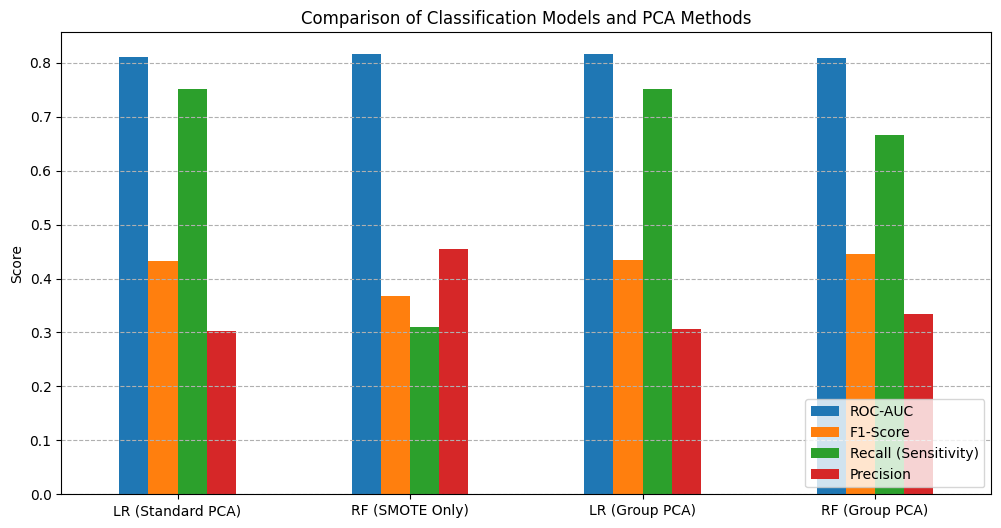

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Define LR with Standard PCA and get its metrics ---
# This uses the 'preprocessor' defined earlier in Lz4LaoQ_QDli, which includes Standard PCA
lr_standard_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=2000)

lr_standard_pipe = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    imputer_step, # Unpack individual steps from original 'preprocessor' sklearn.pipeline
    scaler_step,  # Unpack individual steps from original 'preprocessor' sklearn.pipeline
    pca_step,     # Unpack individual steps from original 'preprocessor' sklearn.pipeline
    ('classifier', lr_standard_model)
])

param_grid_lr_standard = {
    'classifier__C': [0.01, 1.0, 100.0],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver': ['liblinear']
}

print("\n--- Training LR with Standard PCA ---")
lr_search_standard = RandomizedSearchCV(
    estimator=lr_standard_pipe,
    param_distributions=param_grid_lr_standard,
    n_iter=10,
    scoring='roc_auc',
    cv=cv_folds,
    verbose=0,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
lr_search_standard.fit(X_train, y_train)

best_lr_standard = lr_search_standard.best_estimator_
print(f"Best LR (Standard PCA) Params: {lr_search_standard.best_params_}")

lr_metrics = evaluate_model(best_lr_standard, X_test, y_test, "LR with Standard PCA")

# --- Now, collect all metrics ---
all_metrics = {
    "LR (Standard PCA)": lr_metrics,
    "RF (SMOTE Only)": rf_metrics, # Renamed to be more accurate
    "LR (Group PCA)": lr_metrics_group,
    "RF (Group PCA)": rf_metrics_group,
}

comparison_df = pd.DataFrame(all_metrics).T
print("\n--- Model Performance Comparison (ROC-AUC focused) ---")
print(comparison_df.sort_values(by='ROC-AUC', ascending=False))

# Visualization of key metrics (e.g., ROC-AUC and F1-Score)
comparison_df[['ROC-AUC', 'F1-Score', 'Recall (Sensitivity)', 'Precision']].plot(
    kind='bar',
    figsize=(12, 6),
    rot=0
)
plt.title('Comparison of Classification Models and PCA Methods')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')
plt.show()